# 3D Image Classification with [MEDICAI](https://github.com/innat/medic-ai)

This tutorials shows how to use [`medicai`](https://github.com/innat/medic-ai), a [`keras`](https://keras.io/) based medical image processing library to train a 3D classification task. We will be using [**Swin Transformer**](https://github.com/SwinTransformer/Video-Swin-Transformer) from [`medicai`](https://github.com/innat/medic-ai).

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import zipfile

# Install Packages

At the moment, we will be installing `medicai` from source. Later it will be replaced with `pip`.

In [2]:
!pip install git+https://github.com/innat/medic-ai.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
os.environ["KERAS_BACKEND"] = "tensorflow" # tensorflow, torch, jax

from medicai.utils.general import hide_warnings
hide_warnings()

import keras

from medicai.models import SwinTransformer
from medicai.transforms import (
    Compose,
    ScaleIntensityRange,
    RandRotate90,
    Resize
)
keras.backend.backend()

E0000 00:00:1745351173.054847      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745351173.124903      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


'tensorflow'

The following cell for getting data is taken from [here](https://keras.io/examples/vision/3D_image_classification/).

In [4]:
cache_dir = os.getcwd()

# normal CT scans
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
filename = keras.utils.get_file("CT-0.zip", url, cache_dir=cache_dir)

# abnormal CT scans
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"
filename2 = keras.utils.get_file("CT-23.zip", url, cache_dir=cache_dir)

# Make a directory to store the data.
os.makedirs("MosMedData", exist_ok=True)

# Unzip data in the newly created directory.
with zipfile.ZipFile(filename, "r") as z_fp:
    z_fp.extractall("MosMedData")

with zipfile.ZipFile(filename2, "r") as z_fp:
    z_fp.extractall("MosMedData")


1065471431/1065471431 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
1045162547/1045162547 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


In [5]:
# Folder "CT-0" consist of CT scans having normal lung tissue,
# no CT-signs of viral pneumonia.
normal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-0", x)
    for x in os.listdir("MosMedData/CT-0")
]
# Folder "CT-23" consist of CT scans having several ground-glass opacifications,
# involvement of lung parenchyma.
abnormal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-23", x)
    for x in os.listdir("MosMedData/CT-23")
]

print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))

abnormal_labels = np.array([1 for _ in range(len(abnormal_scan_paths))])
normal_labels = np.array([0 for _ in range(len(normal_scan_paths))])
X = np.concatenate([normal_scan_paths, abnormal_scan_paths])
y = np.concatenate([normal_labels, abnormal_labels])
print('Total sample ', X.shape, y.shape)

CT scans with normal lung tissue: 100
CT scans with abnormal lung tissue: 100
Total sample  (200,) (200,)


# Training and Validation Split

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    stratify=y,
    test_size=0.30
)

print('Verify number of samples per dataset')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

print('Training data distribution')
print(np.array(np.unique(y_train, return_counts=True)).T)

print('Validation data distribution')
print(np.array(np.unique(y_test, return_counts=True)).T)

Verify number of samples per dataset
(140,) (140,) (60,) (60,)
Training data distribution
[[ 0 70]
 [ 1 70]]
Validation data distribution
[[ 0 30]
 [ 1 30]]


# Transformation

- For preprocessing, we will be using data scaling and resizing to target shape.
- For augmentation, we will be using random rotate 90 degree at random.

**Note**: Each sample expects to process single sample to process and shape of the sample should be `depth, height, width, channel` format.

In [7]:
def train_transformation(image, label):
    data = {"image": image, "label": label}
    pipeline = Compose(
        [
            ScaleIntensityRange(
                keys=["image"], 
                a_min=-175, 
                a_max=250, 
                b_min=0.0, 
                b_max=1.0, 
                clip=True
            ),
            Resize(
                keys=["image"], 
                mode=['bilinear'], 
                spatial_shape=(96,96,96)
            ),
            RandRotate90(
                keys=["image"], 
                prob=0.1, 
                max_k=3, 
                spatial_axes=(1, 2)
            )
        ]
    )
    result = pipeline(data)
    return result.data["image"], result.data["label"]

def val_transformation(image, label):
    data = {"image": image, "label": label}
    pipeline = Compose(
        [
            ScaleIntensityRange(
                keys=["image"], 
                a_min=-175, 
                a_max=250, 
                b_min=0.0, 
                b_max=1.0, 
                clip=True
            ),
            Resize(
                keys=["image"], 
                mode=['bilinear'], 
                spatial_shape=(96,96,96)
            ),
        ]
    )
    result = pipeline(data)
    return result.data["image"], result.data["label"]

# Dataloader

In [8]:
import nibabel as nib

class NiftiDataLoader(keras.utils.PyDataset):
    def __init__(
        self, 
        image_paths, 
        labels,
        batch_size=1, 
        dim=(128, 128, 128), 
        shuffle=True, 
        training=True
    ):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.training = training
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        image_paths_batch = [self.image_paths[k] for k in indices]
        labels_batch = [self.labels[k] for k in indices]
        
        X = np.zeros((self.batch_size, *self.dim, 1), dtype=np.float32)
        y = np.zeros((self.batch_size), dtype=np.float32)

        for i, (img_path, label) in enumerate(zip(image_paths_batch, labels_batch)):
            # Load and preprocess image
            img = nib.load(img_path).get_fdata()
            img = np.transpose(img, (2, 1, 0)) # whd -> dhw
            
            # Add channel dimension if needed
            if img.ndim == 3:
                img = np.expand_dims(img, axis=-1)

            if self.training:
                img, label = train_transformation(img, label)
            else:
                img, label = val_transformation(img, label)
            
            X[i] = img
            y[i] = label
        
        return X, y

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

In [9]:
input_shape=(96, 96, 96)
batch_size=3

train_loader = NiftiDataLoader(
    image_paths=X_train,
    labels=y_train,
    batch_size=batch_size,
    dim=input_shape,
    shuffle=True,
    training=True
)

val_loader = NiftiDataLoader(
    image_paths=X_test,
    labels=y_test,
    batch_size=batch_size,
    dim=input_shape,
    shuffle=False,
    training=False
)

**visualize**

In [10]:
x, y = next(iter(train_loader))
x.shape, y.shape

I0000 00:00:1745351220.937915      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745351220.938591      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


((3, 96, 96, 96, 1), (3,))

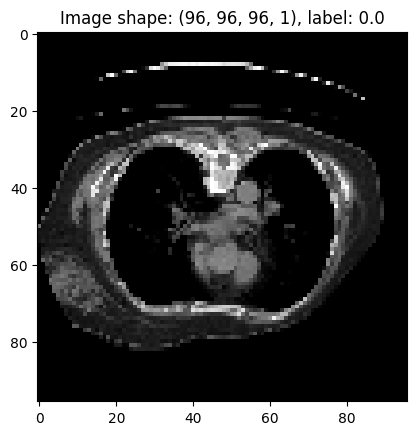

In [11]:
test_image = x[2]
test_label = y[2]
plt.imshow(test_image[test_image.shape[0]//2], cmap='gray')
plt.title(f'Image shape: {test_image.shape}, label: {test_label}')
plt.show()

# Create Model

In [12]:
model = SwinTransformer(
    input_shape=(*input_shape, 1),
    num_classes=1,
    classifier_activation='sigmoid',
)
model.compile(
    optimizer=keras.optimizers.AdamW(
        learning_rate=1e-4, weight_decay=1e-5
    ),
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[keras.metrics.BinaryAccuracy(name='acc')],
    jit_compile=False,
)

In [13]:
model.summary()

Model: "swin_transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 96, 1)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ swin_backbone (SwinBackbone)         │ (None, 3, 3, 3, 768)        │       8,062,002 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling3d             │ (None, 768)                 │               0 │
│ (GlobalAveragePooling3D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 1)                   │             769 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,062,771 (30.76 MB)

 Trainable params: 8,062,771 (30.76 MB)

 Non-trainable params: 0 (0.00 B)

# Training

In [14]:
history = model.fit(
    train_loader, 
    epochs=10,
    validation_data=val_loader
)

Epoch 1/10


I0000 00:00:1745351269.504290     127 cuda_dnn.cc:529] Loaded cuDNN version 90300


46/46 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - acc: 0.5228 - loss: 1.8531 - val_acc: 0.5000 - val_loss: 1.3620
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - acc: 0.4790 - loss: 0.8785 - val_acc: 0.4500 - val_loss: 1.0817
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - acc: 0.4838 - loss: 0.9117 - val_acc: 0.6000 - val_loss: 0.6575
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - acc: 0.6418 - loss: 0.7020 - val_acc: 0.6500 - val_loss: 0.6681
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - acc: 0.4899 - loss: 0.7307 - val_acc: 0.6833 - val_loss: 0.6282
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - acc: 0.6735 - loss: 0.6509 - val_acc: 0.4667 - val_loss: 0.8029
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - acc: 0.6846 - loss: 0.6171 - val_acc: 0.6000 - val_loss: 0.6677
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - acc: 0.6889 - loss: 0.5634 - val_acc: 0.5500 - val_loss: 0.7791
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - acc: 0.6650 - loss: 0.

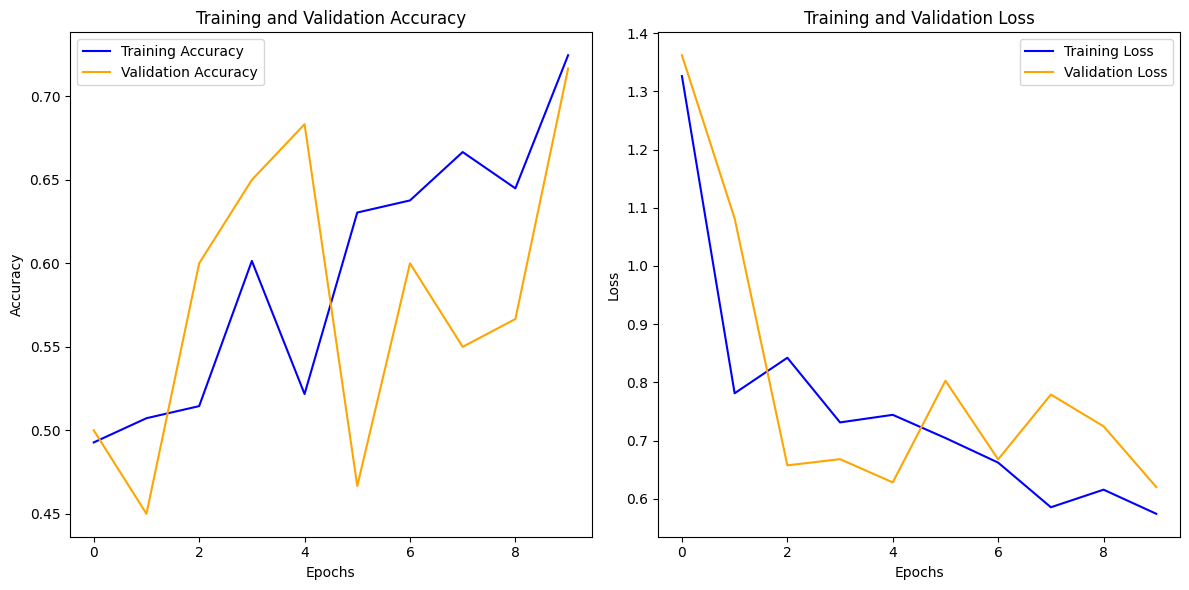

In [15]:
# Extract accuracy and loss values
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
plt.figure(figsize=(12, 6))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label="Training Accuracy", color='blue')
plt.plot(val_acc, label="Validation Accuracy", color='orange')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(loss, label="Training Loss", color='blue')
plt.plot(val_loss, label="Validation Loss", color='orange')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Inference

In [16]:
label_map = {0: "normal", 1: "abnormal"}

In [17]:
for i, sample in enumerate(val_loader):
    batch_x, batch_y = sample

    for x, y in zip(batch_x, batch_y):
        x = x[None, ...]
        y_label = label_map[int(y)]
        
        y_pred = model.predict(x, verbose=0)[0] > 0.5
        y_pred = y_pred.astype('int')[0]
        y_pred_label = label_map[y_pred]
        
        print(
            f'True label: {y_label} |',
            f'Predicted label: {y_pred_label}'
        )
        print("=" * 50)

    if i > 1:
        break

True label: abnormal | Predicted label: normal
True label: normal | Predicted label: abnormal
True label: abnormal | Predicted label: abnormal
True label: abnormal | Predicted label: normal
True label: normal | Predicted label: normal
True label: normal | Predicted label: normal
True label: normal | Predicted label: abnormal
True label: abnormal | Predicted label: normal
True label: abnormal | Predicted label: normal
